In [50]:
import numpy as np
from scipy.stats import uniform, bernoulli
import itertools
import matplotlib.pyplot as plt

In [51]:
class ErdosRenyiFJ:
    def __init__(self, n, p, w_lower, w_upper, internal_lower, internal_upper, internal_dtbn="bernoulli", directed=False):
        '''
        n: number of nodes
        p: probably that each edge exists
        w_lower: min initial weight
        w_upper: max initial weight
        internal_lower: min internal opinion
        internal_upper: max internal opinion
        internal_dtbn: Distribution of internal opinions. Either "bernoulli" or "uniform".
        '''
        assert w_lower >= 0
        assert w_upper >= w_lower
        self.n = n
        self.directed = directed
        if directed:
            self.weights = bernoulli.rvs(p, size=[n,n]) * uniform.rvs(loc=w_lower, scale=w_upper - w_lower, size=[n, n])
            # zero out the diagonal since w_{ii} is only used for internal opinions rather than expressed opinions
            for i in range(n):
                self.weights[i][i] = 0
        else:
            upper_triangular_weights = np.triu(uniform.rvs(
                loc=w_lower, scale=w_upper - w_lower, size=[n, n])* bernoulli.rvs(p, size=[n,n]), k=1)
            self.weights = upper_triangular_weights + upper_triangular_weights.T - np.diag(upper_triangular_weights.diagonal())

        self.internal_dtbn = internal_dtbn
        if internal_dtbn == "bernoulli":
            self.internal = bernoulli.rvs(p=0.5, size=n)  # Bernoulli
        elif internal_dtbn == "uniform":
            self.internal = uniform.rvs(loc=internal_lower, scale=internal_upper - internal_lower, size=n)  # Uniform random
        else:
            raise Exception("Unknown internal opinion distribution: " + internal_dtbn)
        
        self.expressed = self.internal.copy()

    def __repr__(self):
        return f'weights: \n{self.weights}\ninternal: {self.internal}\nexpressed: {self.expressed}'

    def laplacian(self):
        degree_matrix = np.diag(np.sum(self.weights, axis=1))
        laplacian = degree_matrix - self.weights
        return laplacian

    def disagreement(self):
        disagreement = 0
        for i, j in itertools.product(range(self.n), range(self.n)):
            disagreement += abs(self.weights[i][j]) * (self.expressed[i] - self.expressed[j]) ** 2
        return disagreement

    def polarization(self):
        avg_expressed = np.sum(self.expressed) / self.n
        mean_centered_expressed = self.expressed - avg_expressed
        return np.dot(mean_centered_expressed, mean_centered_expressed)

    def update_weights(self):
        pass

    def run_one_step(self):
        new_expressed = self.expressed.copy()
        self.expressed = (self.internal + self.weights @ self.expressed) / (1 + np.sum(self.weights, axis=1))
        self.update_weights()
        
    def run_t_steps(self, t):
        ''' Run t steps of FJ '''
        for i in range(t):
            self.run_one_step()

    def to_nx_graph(self, threshold):
        '''
        Convert graph to networkx graph (with weighted edges), where edge between i and j exists if weights[i][j] >= threshold.
        The networkx graph is directed if and only if this graph is directed.
        '''
        nodes = list(range(self.n))
        edges = []
        
        for i in range(self.n):
            for j in range(self.n):
                if self.weights[i][j] >= threshold:
                    edges.append((i, j, self.weights[i][j]))
        
        # Create a weighted graph
        if self.directed:
            G = nx.DiGraph()
        else:
            G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_weighted_edges_from(edges)
        return G

    def plot_network(self, threshold=0.001, title="Erdos Renyi Graph"):
        '''
        Plot the network, where edge between i and j exists if weights[i][j] >= threshold.
        '''
        G = self.to_nx_graph(threshold)
        
        # Get positions for nodes
        pos = nx.spring_layout(G)  # Spring layout for a visually appealing result
        
        # Draw the graph
        plt.figure(figsize=(8, 6))

        node_cmap=plt.cm.winter
        edges, edge_weights = zip(*nx.get_edge_attributes(G, 'weight').items())
        nx.draw(G,
                pos,
                node_color=[node_cmap(self.expressed[i]) for i in range(self.n)],
                edgelist=edges,
                edge_color=edge_weights,
                width=2.0,
                node_size=10,
                edge_cmap=plt.cm.Blues)
        
        plt.title(title)
        plt.show()

    def get_components(self, threshold=0.001):
        '''
        Returns the connected components (if undirected)
        or weakly connected components (if directed) of this graph,
        sorted in decreasing order by size.
        '''
        G = self.to_nx_graph(threshold)
        if self.directed:
            return sorted(nx.weakly_connected_components(G), key=len, reverse=True)
        else:
            return sorted(nx.connected_components(G), key=len, reverse=True)

    def largest_component_size(self, threshold=0.001):
        '''
        Returns the size of the largest connected component (if undirected)
        or the size of the largest weakly connected component (if directed).
        '''
        conn_comps = self.get_components(threshold)
        return len(conn_comps[0])

    def num_components(self, threshold=0.001):
        '''
        Returns the number of connected components (if undirected)
        or the number of weakly connected components (if directed).
        '''
        conn_comps = self.get_components(threshold)
        return len(conn_comps)

In [4]:
class HalvingFJ(ErdosRenyiFJ):
    def __init__(self, n, p, w_lower, w_upper, internal_lower, internal_upper, theta):
        super().__init__(n, p, w_lower, w_upper, internal_lower, internal_upper)
        self.theta = theta
    
    def update_weights(self):
        self.weights = (1 - (np.abs(self.expressed.reshape(-1, 1) - self.expressed) > self.theta) * 1/2) * self.weights

In [4]:
G = ErdosRenyiFJ(300, 0.5, 0, 1, 0, 1)
G.run_t_steps(1000)
print(G)
print(G.disagreement())
print(G.polarization())

weights: 
[[0.         0.14173443 0.         ... 0.79592435 0.         0.85184657]
 [0.         0.         0.         ... 0.         0.34283255 0.        ]
 [0.         0.         0.         ... 0.         0.97693047 0.        ]
 ...
 [0.20444956 0.67208516 0.71359346 ... 0.         0.63540153 0.        ]
 [0.         0.         0.90464788 ... 0.00864943 0.         0.70140254]
 [0.         0.         0.         ... 0.33240848 0.         0.        ]]
internal: [0.97705632 0.96013951 0.33662317 0.16705465 0.3892955  0.72458555
 0.62306134 0.20190139 0.65358193 0.75945821 0.55536201 0.16704061
 0.3856527  0.29115205 0.47282208 0.55731124 0.55020296 0.49740044
 0.44970989 0.04716374 0.92475532 0.45244105 0.00986381 0.55821172
 0.67870832 0.35536712 0.23815796 0.27475265 0.95011671 0.11609549
 0.51882404 0.82600946 0.8655082  0.58122375 0.38115418 0.71290111
 0.19465772 0.01430988 0.08399045 0.27581423 0.86646085 0.36561753
 0.64854935 0.73462526 0.71159303 0.44882872 0.42732729 0.86407751


In [5]:
G = HalvingFJ(10, 0.5, 0, 1, 0, 1, theta=0.2)
G.run_t_steps(1000)
print(G)

weights: 
[[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  3.66029036e-001 1.29441806e-001 0.00000000e+000 2.93249019e-001
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 9.76951112e-001
  0.00000000e+000 4.36076254e-001 5.57330877e-001 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [1.45840846e-001 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 9.27843918e-001 8.40964868e-001 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [7.62563173e-001 1.23904006e-001 0.00000000e+000 0.00000000e+000
  0.00000000e+000 9.26319406e-001 0.00000000e+000 0.00000000e+000
  2.74693434e-001 0.00000000e+000]
 [5.74467239e-001 8.64740597e-001 0.00000000e+000 8.54077593e-001
  0.00000000e+000 0.00000000e+000 5.09485855e-001 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 6.49749242e-001 9.75954401e-001
  0.00000000e+000 0.00000000e+000 2.59838068e-001 6.20460253e-002
  2.72497456e-001 1.533

In [5]:
def get_disagreement_polarization(model, num_steps=1000, num_trials=100):
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G = model()
        G.run_t_steps(num_steps)
        disagreements.append(G.disagreement())
        polarizations.append(G.polarization())
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

### Basic FJ model on $G_{n,p}$ for $p=\frac12$ where all weights are $w_{ij}$ uniform $[0,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d.

In [7]:
model = lambda: ErdosRenyiFJ(n=300, p=1/2, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1)
get_disagreement_polarization(model, num_steps=1000, num_trials=10)

(0.6538339263843007, 0.004411090694726467)

### Basic FJ model on $G_{n,p}$ for $p=\frac{1}{n}$ where all weights are $w_{ij}$ uniform $[0,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d.

In [8]:
model = lambda: ErdosRenyiFJ(n=300, p=1/300, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1)
get_disagreement_polarization(model, num_steps=1000, num_trials=10)

(7.7689025490922194, 16.155673579692778)

## Weight Halving Threshold Model with uniform threshold $\theta_{ij} = \theta$

In [9]:
average_disagreements = []
average_polarizations = []
thetas = np.linspace(0,1,num=10)
for theta in thetas:
    model = lambda: HalvingFJ(n=300, p=1/2, w_lower=0, w_upper=1, internal_lower=0, internal_upper=1, theta=theta)
    average_disagreement, average_polarization = get_disagreement_polarization(model, num_steps=1000, num_trials=10)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)

print(average_disagreements)
print(average_polarizations)

[3.536101928456132e-298, 0.6412466462955295, 0.6496173381724129, 0.6650561542571085, 0.6447864782420216, 0.6563715257082078, 0.6405340055323453, 0.6537961982500137, 0.670180451668666, 0.6313345308334055]
[25.288380289661834, 0.004341687472966883, 0.004365523265207536, 0.004483115556433479, 0.004349180577274682, 0.0044355515981550605, 0.004334145183620366, 0.00441932651327931, 0.004501732107527139, 0.004270827874171509]


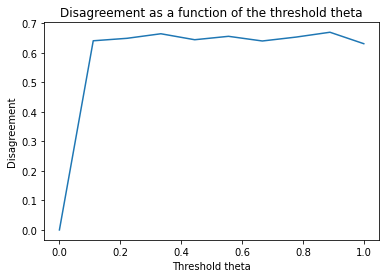

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the threshold theta')
ax.plot(thetas, average_disagreements)
fig.savefig('threshold_model_halve_weight_disagreement.png')

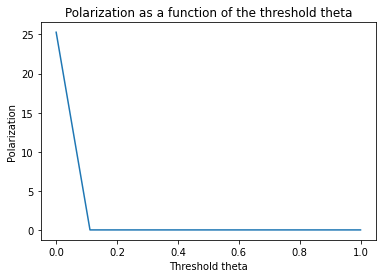

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the threshold theta')
ax.plot(thetas, average_polarizations)
fig.savefig('threshold_model_halve_weight_polarization.png')

# Preprocessing Datasets

## Who-trust-whom Bitcoin platform: directed, weight represents trust, normalized to [-1, 1]

In [23]:
import csv
import networkx as nx

G = nx.DiGraph()

with open('dataset/soc-sign-bitcoinotc.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        source = int(row[0])
        target = int(row[1])
        rating = float(row[2])

        # Normalize the rating to [0, 1]
        normalized_rating = np.maximum(rating, 0) / 10.0

        G.add_node(source)
        G.add_node(target)
        G.add_edge(source, target, weight=normalized_rating)

In [24]:
print(G.number_of_nodes())
print(G.number_of_edges())

5881
35592


## Opinion review website with who-trust-whom, weights are either -1 or 1

In [6]:
import networkx as nx

G = nx.DiGraph()

with open('dataset/soc-sign-epinions.txt', 'r') as file:
    for line in file:
        if line.startswith('#'):
            continue
        parts = line.strip().split()
        if len(parts) != 3:
            continue
        source, target, sign = parts
        source = int(source)
        target = int(target)
        weight = int(sign)  # Should be either 1 or -1

        G.add_node(source)
        G.add_node(target)
        G.add_edge(source, target, weight=weight)

In [7]:
print(G.number_of_nodes())
print(G.number_of_edges())

131825
841345


### EU research institution email communication, weights either 0 or 1. People who wrote at least one email have an edge with weight 1 in between. Also people from same department are assumed to know each other (has an edge in between).

In [53]:
import networkx as nx
from itertools import combinations

# Initialize an undirected graph
G = nx.Graph()

group_file = 'dataset/email-EU/email-EU-core-department-labels.txt'
group_dict = {}

with open(group_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 2:
            continue
        node_id, group_id = parts
        node_id = int(node_id)
        group_id = int(group_id)
        G.add_node(node_id)
        if group_id not in group_dict:
            group_dict[group_id] = []
        group_dict[group_id].append(node_id)

# Add edges between all nodes in the same group
for group_nodes in group_dict.values():
    for u, v in combinations(group_nodes, 2):
        if not G.has_edge(u, v):
            G.add_edge(u, v, weight=1)

edge_file = 'dataset/email-EU/email-EU-core.txt'
with open(edge_file, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 2:
            continue
        u, v = parts
        u = int(u)
        v = int(v)
        G.add_node(u)
        G.add_node(v)
        if not G.has_edge(u, v):
            G.add_edge(u, v, weight=1)

for u, v, data in G.edges(data=True):
    assert data['weight'] == 1, f"Edge ({u}, {v}) has incorrect weight {data['weight']}"

In [54]:
print(G.number_of_nodes())
print(G.number_of_edges())

1005
34857


## Visualize the graph G (without opinion assigned yet)

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42)

edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]

# Create a color map
cmap = plt.cm.seismic  # Blue for negative, white for neutral, red for positive
norm = mcolors.Normalize(vmin=-1, vmax=1)
edge_colors = [cmap(norm(w)) for w in weights]

node_size = 10
edge_width = 0.2

plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='grey', alpha=0.7)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_width, alpha=0.5, arrowsize=5)

plt.axis('off')
plt.title('Network G with influence: red positive, blue negative', fontsize=15)
plt.show()

/var/folders/5j/zxz7w9h16kn7fby69f73bgs00000gn/T/ipykernel_39029/1031906804.py:20: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_width, alpha=0.5, arrowsize=5)


KeyboardInterrupt: 

## Now choose a graph G generated from one of the dataset. Compute the converged expressed opinion with threshold model.

In [67]:
import numpy as np
import networkx as nx
from scipy.stats import uniform
from scipy.special import expit

class SelfDefinedGraphFJ(HalvingFJ):
    def __init__(self, graph, internal_lower, internal_upper, model_type="normal", neg_weights=False, theta=None):
        self.graph = graph  # networkx graph
        self.node_list = list(graph.nodes())
        self.node_to_index = {node: idx for idx, node in enumerate(self.node_list)}
        self.index_to_node = {idx: node for idx, node in enumerate(self.node_list)}
        self.neg_weights = neg_weights
        self.n = len(self.node_list)
        
        # Initialize weights matrix (allowing negative weights)
        self.weights = np.zeros((self.n, self.n))
        for u, v, data in graph.edges(data=True):
            i = self.node_to_index[u]
            j = self.node_to_index[v]
            self.weights[i, j] = data['weight']
        np.fill_diagonal(self.weights, 0)

        self.internal = bernoulli.rvs(p=0.5, size=self.n)  # Bernoulli   
        # self.internal = uniform.rvs(loc=internal_lower, scale=internal_upper - internal_lower, size=self.n)  # uniform
        self.expressed = self.internal.copy()
        
        self.model_type = model_type
        self.theta = theta if theta is not None else 0.5  # Default theta
    
    def __repr__(self):
        return f'weights: \n{self.weights}\ninternal: {self.internal}\nexpressed: {self.expressed}'
    
    def disagreement(self):
        disagreement = 0
        for u, v, data in self.graph.edges(data=True):
            i = self.node_to_index[u]
            j = self.node_to_index[v]
            weight = abs(self.weights[i, j])
            disagreement += weight * (self.expressed[i] - self.expressed[j]) ** 2
        return disagreement
    
    def polarization(self):
        avg_expressed = np.mean(self.expressed)
        mean_centered_expressed = self.expressed - avg_expressed
        return np.dot(mean_centered_expressed, mean_centered_expressed)
    
    def update_weights(self):
        if self.model_type == "normal":
            pass
        elif self.model_type == "threshold":
            for u, v in self.graph.edges():
                i = self.node_to_index[u]
                j = self.node_to_index[v]
                if abs(self.expressed[i] - self.expressed[j]) >= self.theta:
                    self.weights[i, j] /= 2
        else:
            raise ValueError(f"Unknown model_type '{self.model_type}'. Supported types: 'normal', 'threshold'.")

    def run_one_step(self):
        if self.neg_weights:
            total_influence = self.internal + self.weights @ self.expressed
            self.expressed = expit(total_influence)
            self.update_weights()
        else:
            new_expressed = self.expressed.copy()
            self.expressed = (self.internal + self.weights @ self.expressed) / (1 + np.sum(self.weights, axis=1))
            self.update_weights()
    
    def run_t_steps(self, t):
        for _ in range(t):
            self.run_one_step()

    def to_nx_graph(self, threshold):
        '''
        Convert graph to networkx graph (with weighted edges), where edge between i and j exists if weights[i][j] >= threshold.
        The networkx graph is directed if and only if this graph is directed.
        '''
        nodes = list(range(self.n))
        edges = []
        
        for i in range(self.n):
            for j in range(self.n):
                if self.weights[i][j] >= threshold:
                    edges.append((i, j, self.weights[i][j]))
        
        # Create a weighted graph
        G = nx.DiGraph()
        G.add_nodes_from(nodes)
        G.add_weighted_edges_from(edges)
        return G

In [57]:
def get_disagreement_polarization_once(model, num_steps=1000):
    '''
    Postcondition: model will be advanced by num_steps at the end of the function
    '''
    model.run_t_steps(num_steps)
    return model.disagreement(), model.polarization()

Average Disagreement: 446.1703166538538
Average Polarization: 876.2211089204205


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

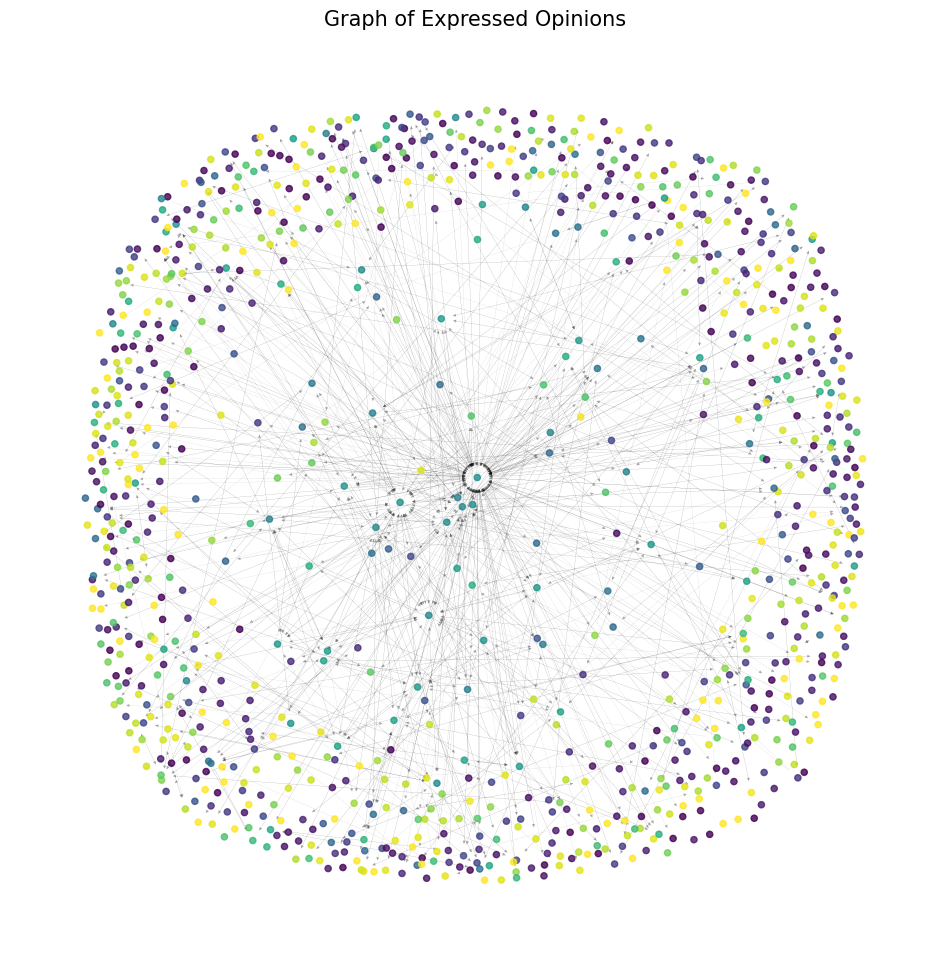

In [73]:
# Instantiate the model
model = SelfDefinedGraphFJ(graph=G, internal_lower=0, internal_upper=1, model_type="normal", neg_weights=False, theta=0.03)
avg_disagreement, avg_polarization = get_disagreement_polarization_once(model, num_steps=100)
print(f"Average Disagreement: {avg_disagreement}")
print(f"Average Polarization: {avg_polarization}")
plot_graph_with_opinions(model, num_nodes=1000)

Average Disagreement: 2.1942979785130088e-26
Average Polarization: 1470.1305900356383


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

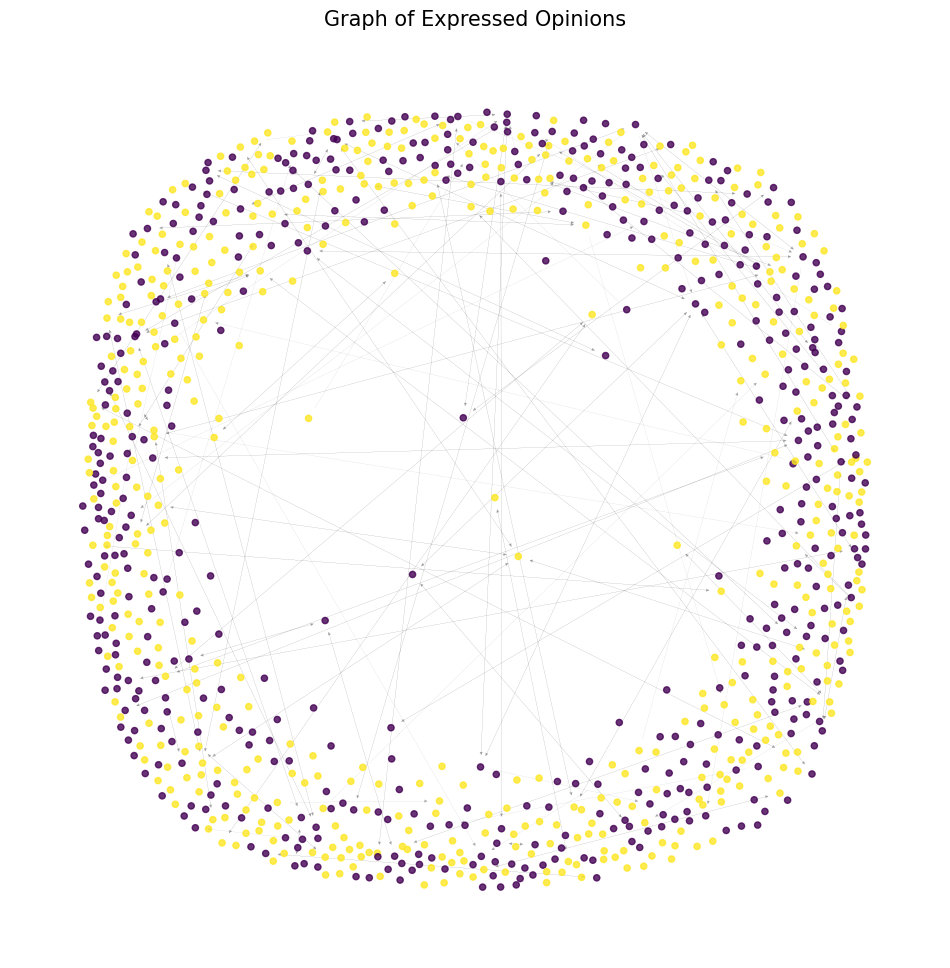

In [76]:
# Instantiate the model
model = SelfDefinedGraphFJ(graph=G, internal_lower=0, internal_upper=1, model_type="threshold", neg_weights=False, theta=0.1)
avg_disagreement, avg_polarization = get_disagreement_polarization_once(model, num_steps=100)
print(f"Average Disagreement: {avg_disagreement}")
print(f"Average Polarization: {avg_polarization}")
plot_graph_with_opinions(model, num_nodes=1000)

In [ ]:
expressed_opinions = model().expressed

### Visualization of the final graph with expressed opinion

In [72]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
import numpy as np

def plot_graph_with_opinions(model, num_nodes=-1):
    # num_nodes is the number of random nodes that we select to plot a subgraph. If num_nodes == -1, plot the entire graph.
    # model should be the final model, not a lambda function
    # Choose a colormap suitable for values in [0, 1]
    if num_nodes == -1:
        num_nodes = model.n

    random_nodes = np.random.choice(np.arange(0, model.n), num_nodes, replace=False)
    expressed_opinions = model.expressed
    G = model.to_nx_graph(threshold=0.001).subgraph(random_nodes)
    cmap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=0, vmax=1)
    
    # node_colors = [expressed_opinions[model.node_to_index[node]] for node in G.nodes()]
    node_colors = [expressed_opinions[node] for node in G.nodes()]
    node_colors_mapped = [cmap(norm(opinion)) for opinion in node_colors]
    
    pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42)
    node_size = 20
    edge_width = 0.1
    
    # Plot the graph
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_size,
        node_color=node_colors,
        cmap=cmap,
        vmin=0,
        vmax=1,
        alpha=0.8
    )
    nx.draw_networkx_edges(
        G,
        pos,
        width=edge_width,
        edge_color='black',
        alpha=0.3,
        arrowsize=5
    )
    
    plt.axis('off')
    plt.title('Graph of Expressed Opinions', fontsize=15)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Expressed Opinion', rotation=270, labelpad=15)  
    plt.show()

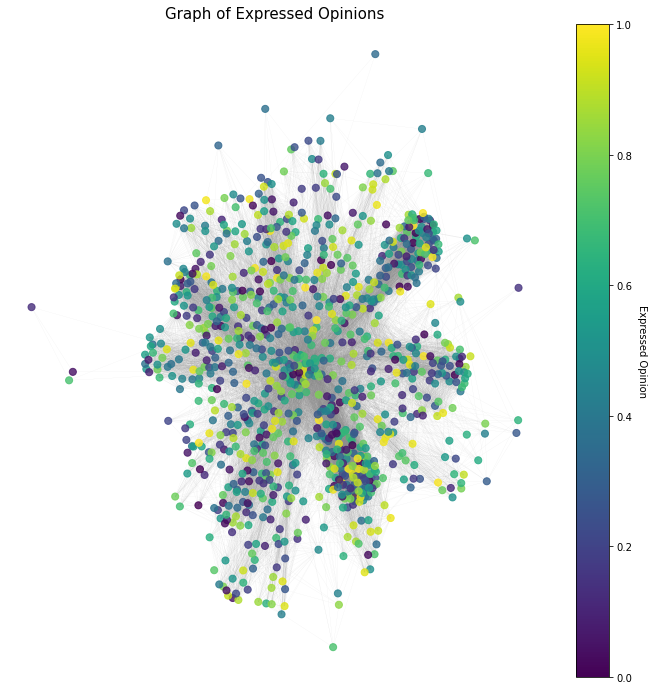

In [66]:
plot_graph_with_opinions(model)

# Trash (To be cleaned)

### Negative weight FJ model on $G_{n,p}$ for $p=\frac12$ where all weights are $w_{ij}$ uniform $[-1,1]$ i.i.d., internal opinions are uniform $[0,1]$ i.i.d. Using sigmoid function to normalize

In [5]:
from scipy.special import expit

In [6]:
def run_fj_and_return_expressed_opinions():
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs(loc=-1, scale=2)
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()
    T = 1000
    for t in range(T):
        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = expit(internal_opinions[i] + sum_neighboring_expressed_opinion)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

num_trials = 10
disagreements = []
polarizations = []
for trial in range(num_trials):
    G, opinions = run_fj_and_return_expressed_opinions()
    disagreements.append(disagreement(G, opinions))
    polarizations.append(polarization(G, opinions))

In [8]:
np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

(np.float64(8809.911938472003), np.float64(58.37903571281214))

### Same setup, but with weight halving threshold model with uniform threshold $\theta_{ij} = \theta$

In [189]:
import networkx as nx
def run_fj_and_return_expressed_opinions(theta):
    # n = 300
    n = 10
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()

    def update_weights():
        for i, nbrs in G.adj.items():
            for j, eattr in nbrs.items():
                if abs(expressed_opinions[i] - expressed_opinions[j]) >= theta:
                    eattr['weight'] /= 2
    T = 1000
    # T = 2
    for t in range(T):

        # print('-' * 50)
        # print('Before update weights:')
        # for i, nbrs in G.adj.items():
        #     for j, eattr in nbrs.items():
        #         print(i, j, round(eattr['weight'], 5), end=';\t')
        #     print()
            
        update_weights()
        # print('After update weights:')
        # for i, nbrs in G.adj.items():
        #     for j, eattr in nbrs.items():
        #         print(i, j, round(eattr['weight'], 5), end=';\t')
        #     print()

        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

def find_disagreement_and_polarization_given_theta(theta):
    num_trials = 3
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G, opinions = run_fj_and_return_expressed_opinions(theta)
        disagreements.append(disagreement(G, opinions))
        polarizations.append(polarization(G, opinions))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

G, expressed_opinions = run_fj_and_return_expressed_opinions(theta=0.01)
for i, nbrs in G.adj.items():
    for j, eattr in nbrs.items():
        print(i, j, round(eattr['weight'], 5), end=';\t')
    print()

# average_disagreements = []
# average_polarizations = []
# thetas = np.linspace(0,1,num=10)
# for theta in thetas:
#     average_disagreement, average_polarization = find_disagreement_and_polarization_given_theta(theta)
#     average_disagreements.append(average_disagreement)
#     average_polarizations.append(average_polarization)

0 1 0.0;	0 2 0.0;	0 3 0.0;	0 4 0.0;	0 6 0.0;	0 9 0.0;	
1 0 0.0;	1 2 0.0;	1 5 0.0;	1 6 0.0;	1 9 0.0;	
2 0 0.0;	2 1 0.0;	2 3 0.0;	2 4 0.0;	2 5 0.0;	2 6 0.0;	2 7 0.15995;	2 8 0.0;	2 9 0.0;	
3 0 0.0;	3 2 0.0;	3 4 0.0;	3 5 0.0;	3 7 0.0;	3 9 0.0;	
4 0 0.0;	4 2 0.0;	4 3 0.0;	4 6 0.0;	4 7 0.0;	
5 1 0.0;	5 2 0.0;	5 3 0.0;	5 6 0.0;	5 7 0.0;	5 8 0.0;	
6 0 0.0;	6 1 0.0;	6 2 0.0;	6 4 0.0;	6 5 0.0;	6 7 0.0;	6 9 0.0;	
7 2 0.15995;	7 3 0.0;	7 4 0.0;	7 5 0.0;	7 6 0.0;	7 8 0.0;	7 9 0.0;	
8 2 0.0;	8 5 0.0;	8 7 0.0;	
9 0 0.0;	9 1 0.0;	9 2 0.0;	9 3 0.0;	9 6 0.0;	9 7 0.0;	


In [178]:
import matplotlib.pyplot as plt

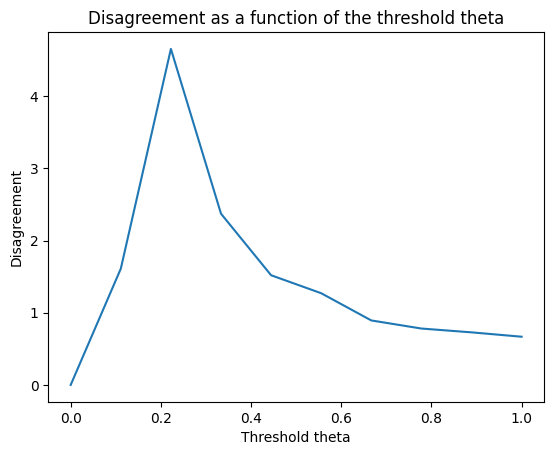

In [26]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the threshold theta')
ax.plot(thetas, average_disagreements)
fig.savefig('threshold_model_halve_weight_disagreement.png')

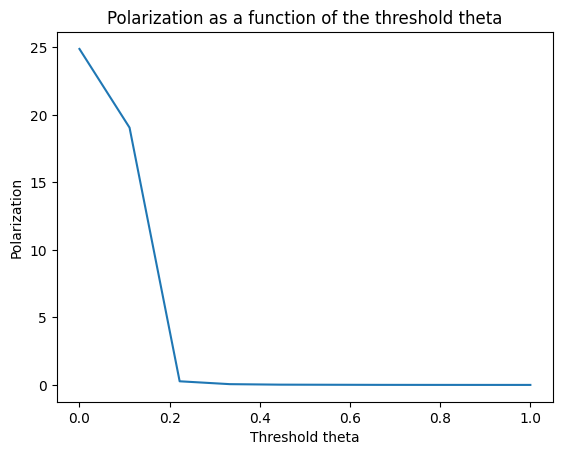

In [27]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the threshold theta')
ax.plot(thetas, average_polarizations)
fig.savefig('threshold_model_halve_weight_polarization.png')

### Same thing, but weight increasing by $\delta = 1/10$

In [31]:
def run_fj_and_return_expressed_opinions(theta):
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()

    delta = 1/10
    def update_weights():
        for i, nbrs in G.adj.items():
            for j, eattr in nbrs.items():
                if abs(expressed_opinions[i] - expressed_opinions[j]) >= theta:
                    eattr['weight'] = min(eattr['weight'] + delta, 1) 
    T = 1000
    for t in range(T):

        update_weights()

        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

def find_disagreement_and_polarization_given_theta(theta):
    num_trials = 3
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G, opinions = run_fj_and_return_expressed_opinions(theta)
        disagreements.append(disagreement(G, opinions))
        polarizations.append(polarization(G, opinions))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

average_disagreements = []
average_polarizations = []
thetas = np.linspace(0,1,num=10)
for theta in thetas:
    average_disagreement, average_polarization = find_disagreement_and_polarization_given_theta(theta)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)

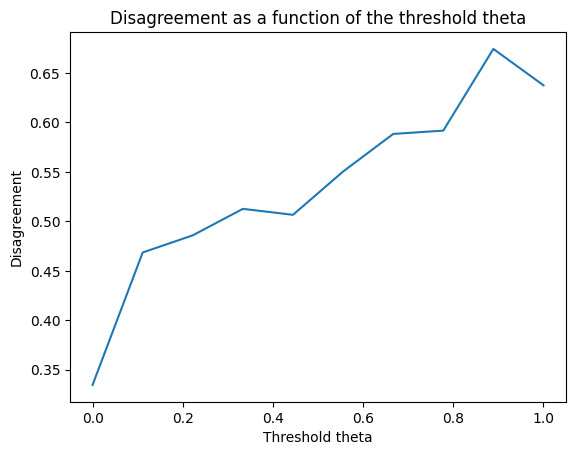

In [32]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the threshold theta')
ax.plot(thetas, average_disagreements)
fig.savefig('threshold_model_increase_weight_disagreement.png')

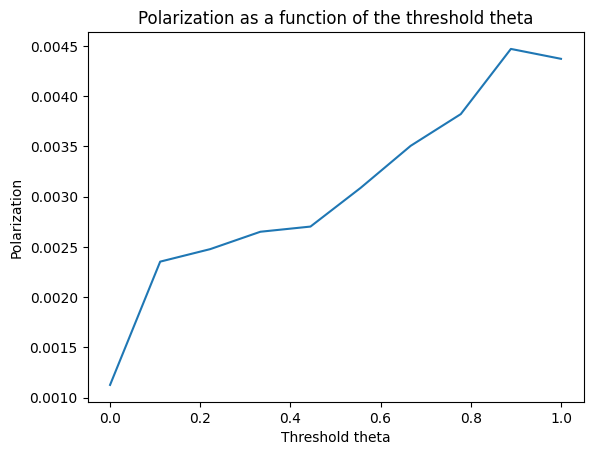

In [33]:
fig, ax = plt.subplots()
ax.set_xlabel('Threshold theta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the threshold theta')
ax.plot(thetas, average_polarizations)
fig.savefig('threshold_model_increase_weight_polarization.png')

### Same thing but using the probabilistic model

In [34]:
from scipy.stats import bernoulli

In [ ]:
def run_fj_and_return_expressed_opinions(delta):
    n = 300
    p = 1/2
    G = nx.erdos_renyi_graph(n, p)
    for edge in G.edges:
        G.edges[edge]['weight'] = uniform.rvs()
    
    internal_opinions = uniform.rvs(size=n)
    expressed_opinions = internal_opinions.copy()

    def update_weights():
        for i, nbrs in G.adj.items():
            for j, eattr in nbrs.items():
                coin_flip = bernoulli.rvs(abs(expressed_opinions[i] - expressed_opinions[j]))
                if not coin_flip:
                    eattr['weight'] = min(eattr['weight'] + delta, 1) 
                else:
                    eattr['weight'] = max(eattr['weight'] - delta, 0)
                    
    T = 1000
    for t in range(T):

        update_weights()

        new_expressed_opinions = expressed_opinions.copy()
        for i, nbrs in G.adj.items():
            sum_neighboring_expressed_opinion = sum(expressed_opinions[j] * eattr['weight'] for j, eattr in nbrs.items())
            sum_neighboring_weight = sum(eattr['weight'] for j, eattr in nbrs.items())
            new_expressed_opinions[i] = (internal_opinions[i] + sum_neighboring_expressed_opinion) / (1 + sum_neighboring_weight)
        expressed_opinions = new_expressed_opinions.copy()
    return G, expressed_opinions

def find_disagreement_and_polarization_given_delta(delta):
    num_trials = 3
    disagreements = []
    polarizations = []
    for trial in range(num_trials):
        G, opinions = run_fj_and_return_expressed_opinions(delta)
        disagreements.append(disagreement(G, opinions))
        polarizations.append(polarization(G, opinions))
    return np.sum(disagreements) / num_trials, np.sum(polarizations) / num_trials

average_disagreements = []
average_polarizations = []
deltas = np.linspace(0,0.5,num=10)
for delta in deltas:
    average_disagreement, average_polarization = find_disagreement_and_polarization_given_delta(delta)
    average_disagreements.append(average_disagreement)
    average_polarizations.append(average_polarization)

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Difference delta')
ax.set_ylabel('Disagreement')
ax.set_title('Disagreement as a function of the difference delta')
ax.plot(deltas, average_disagreements)
fig.savefig('probabilistic_model_disagreement.png')

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Difference delta')
ax.set_ylabel('Polarization')
ax.set_title('Polarization as a function of the difference delta')
ax.plot(deltas, average_polarizations)
fig.savefig('probabilistic_model_polarization.png')